In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

Chúng ta sẽ thực hành trên dataset có tên là tf_flower, đây là dataset liên quan đến các loại hoa của tensorflow

In [2]:
#Loading a dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
#Check số lượng labels
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


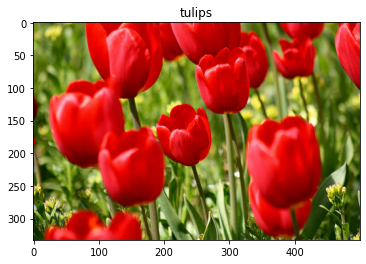

In [4]:
#Show thử một số ảnh. ra
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 180
#Định nghĩa hàm resizing và rescaling
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [6]:
#Định nghĩa 2 augmentations là random flip và random random rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

#CNN

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
23/23 [==============================] - 16s 87ms/step - loss: 1.8173 - accuracy: 0.2977 - val_loss: 1.3781 - val_accuracy: 0.3760
Epoch 2/5
23/23 [==============================] - 2s 60ms/step - loss: 1.2060 - accuracy: 0.4714 - val_loss: 1.2315 - val_accuracy: 0.4932
Epoch 3/5
23/23 [==============================] - 2s 58ms/step - loss: 1.0922 - accuracy: 0.5453 - val_loss: 1.0746 - val_accuracy: 0.5940
Epoch 4/5
23/23 [==============================] - 2s 61ms/step - loss: 1.0412 - accuracy: 0.5869 - val_loss: 1.0468 - val_accuracy: 0.5722
Epoch 5/5
23/23 [==============================] - 2s 58ms/step - loss: 1.0010 - accuracy: 0.6066 - val_loss: 1.0016 - val_accuracy: 0.6240


#VGG16

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
#Chạy cái create_model_notAugment
#import keras_efficientnet_v2
def create_model():

    #pretrained_model  = keras_efficientnet_v2.EfficientNetV2M(dropout=1e-6, num_classes=0,pretrained="imagenet",include_preprocessing=True)
    pretrained_model = pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    last_output = pretrained_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(250, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=pretrained_model.input, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model
model = create_model()
MC=tf.keras.callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True, 
    verbose=1
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[MC]
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - ETA: 0s - loss: 2.0954 - accuracy: 0.2265
Epoch 1: val_accuracy improved from -inf to 0.24251, saving model to best.hdf5
23/23 [==============================] - 13s 357ms/step - loss: 2.0954 - accuracy: 0.2265 - val_loss: 1.6031 - val_accuracy: 0.2425
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.6517 - accuracy: 0.2374
Epoch 2: val_accuracy did not improve from 0.24251
23/23 [==============================] - 5s 166ms/step - loss: 1.6517 - accuracy: 0.2374 - val_loss: 1.6005 - val_accuracy: 0.2425
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.5985 - accuracy: 0.2330
Epoch 3: val_accuracy improved from 0.24251 to 0.27520, saving model to best.hdf5
23/23 [==============================] - 5s 173ms/step - loss: 1.5985 - accuracy: 0.2330 - val_loss: 1.5931 - val_accuracy: 0.2752
Epoch 4/5
23/23 [==============================] - ETA: 0s - loss: 1.5517 - accuracy: 0.2990
Epoch 4: val_accuracy improved f

In [14]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 57ms/step - loss: 1.3178 - accuracy: 0.3896


[1.3178011178970337, 0.3896457850933075]

#Freezing pre-trained model

In [15]:
def create_model():

    #pretrained_model  = keras_efficientnet_v2.EfficientNetV2M(dropout=1e-6, num_classes=0,pretrained="imagenet",include_preprocessing=True)
    pretrained_model = pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    pretrained_model.trainable = False
    last_output = pretrained_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(250, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=pretrained_model.input, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model
model = create_model()
MC=tf.keras.callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True, 
    verbose=1
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Bài tập
1. Hãy thêm một số phương pháp augmentations khác cho model, có thể tìm hiểu các augmentations sau của tf.keras.layers:
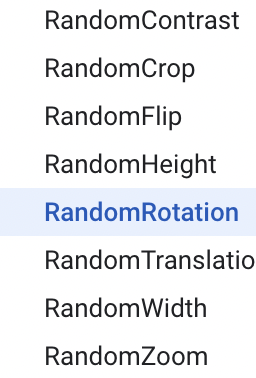
2. Hãy thay model VGG16 thành VGG19 và train thử
3. so sánh kết quả của việc freezing và unfreezing 
Lưu ý: có thể chọn số epoches cần thiết để train